In [1]:
# 사용 상의 편의를 위한 Initial Setting 

# 실행결과를 한 창에 표시
# InteractiveShell.ast_node_interactivity : 'all' | 'last' | 'last_expr' | 'none' (기본값은 'last_expr')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# numpy 소숫점 setting
import numpy as np
np.set_printoptions(precision=7)

# pandas이용하여 grid display
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)         # 최대 표시 줄 수 제한 해제
pd.set_option('display.max_columns', None)  # 최대 표시 컬럼 수 제한 해제
pd.set_option('display.max_colwidth', -1)        # 컬럼내 데이터 표시 제한 해제

# Warning Message ignore
import warnings
# warnings.filterwarnings(action='default')
warnings.filterwarnings(action='ignore')

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
from keras.applications import inception_v3
from keras import backend as K

# 모델을 훈련하지 않음. 이 명령은 모든 훈련 연산을 비활성화 함
K.set_learning_phase(0)

# Convnet기반층만 사용한 인셉션 V3 네트워크를 생성, 사전 훈련된 InceptionV3 가중치와 함께 모델 로드
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

In [4]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [5]:
# 층 이름과 계수를 매핑한 딕셔너리.
# 최대화하려는 손실에 층의 활성화가 기여할 양을 결정
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [6]:
# 손실 텐서를 정의
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # 층 특성의 L2 노름의 제곱을 손실에 추가 (이미지 테두리는 제외하고 손실에 추가)
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

그 다음 경사 상승법 과정을 준비합니다:

In [7]:
# 이 텐서는 생성된 딥드림 이미지를 저장
dream = model.input

# 손실에 대한 딥드림 이미지의 그래디언트를 계산
grads = K.gradients(loss, dream)[0]

# 그래디언트를 정규화
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 Function 객체를 생성
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행합니다
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)

In [8]:
# 가장 작은 것에서 가장 큰 스케일 까지 연속적으로 각 단계에서 정의한 손실이 최대화 되도록 경상 상승법을 수행
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
import numpy as np

step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지
max_loss = 10.

base_image_path = '/home/ubuntu/01_DeepLearningWithPython/Exercise/image/datasets/koala.jpg'

# 기본 이미지를 넘파이 배열로 로드
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집음
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('image size', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='/home/ubuntu/01_DeepLearningWithPython/Exercise/image/datasets/koala_dream.jpg')

image size (391, 522)
... 0 번째 손실 : 1.8923063
... 1 번째 손실 : 2.3579528
... 2 번째 손실 : 3.0748253
... 3 번째 손실 : 3.830983
... 4 번째 손실 : 4.578321
... 5 번째 손실 : 5.3427935
... 6 번째 손실 : 6.066035
... 7 번째 손실 : 6.7950487
... 8 번째 손실 : 7.4892697
... 9 번째 손실 : 8.139108
... 10 번째 손실 : 8.784425
... 11 번째 손실 : 9.407555
image size (548, 731)
... 0 번째 손실 : 3.129119
... 1 번째 손실 : 4.418983
... 2 번째 손실 : 5.5483084
... 3 번째 손실 : 6.5342016
... 4 번째 손실 : 7.485322
... 5 번째 손실 : 8.371445
... 6 번째 손실 : 9.2045965
image size (768, 1024)
... 0 번째 손실 : 3.158132
... 1 번째 손실 : 4.4936233
... 2 번째 손실 : 5.777591
... 3 번째 손실 : 7.0764794
... 4 번째 손실 : 8.5794325


In [10]:
from matplotlib import pyplot as plt

<Figure size 432x288 with 0 Axes>

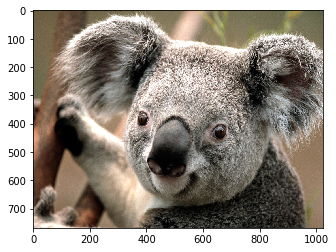

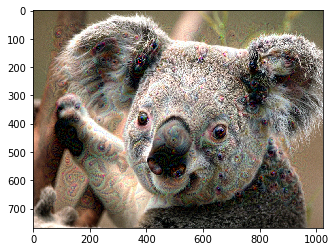

In [11]:
plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()